**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# **Práctica 2.  Aprendizaje en entornos complejos**

## **1. Preparación del Entorno**

### 1.1 Introducción.  

Este notebook se enfoca en la implementación y análisis de un agente que utiliza **Aprendizaje por Refuerzo** para resolver distintos entornos que nos ofrece `gymnasium`.  

Los entornos que vamos a utlizar son: 

 - **FrozenLake (4x4)**

 - **FrozenLake (8x8)**

### 1.2. Instalación de Dependencias

Se instalan las librerías necesarias para trabajar con el entorno de simulación `gymnasium`, lo que permite crear un ambiente controlado donde el agente pueda interactuar y aprender. Este entorno simula una cuadrícula donde el agente debe navegar para alcanzar una meta, mientras se enfrenta a varios desafíos.

In [40]:
%%capture
# ! pip install 'gym[box2d]==0.20.0'
# ! pip install gymnasium[box2d]
# ! pip install "gymnasium[toy-text]
# ! pip install gymnasium 
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tqdm
# ! pip install torch

### 1.3 Librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random

from src_agents import *
from src_plotting import *

### 1.4 Importación de los Entornos 

Se cargan dos entornos diferentes para el agente:
- **FrozenLake (4x4)** es un pequeño lago congelado en el que el agente debe navegar para llegar a su destino, evitando caer en el agua. Este entorno es especialmente útil para un aprendizaje inicial, ya que no es resbaladizo, lo que facilita la comprensión de cómo el agente interactúa con el entorno.

- **CliffWalking** el agente aquí debe caminar a lo largo de un acantilado, evitando caer en él. Este entorno introduce más complejidad, ya que las acciones del agente tienen consecuencias más dramáticas, como caer en el acantilado si no se tiene cuidado, lo que ofrece una mayor oportunidad para evaluar la capacidad del agente de aprender de los castigos y recompensas.



### 1.5 Funciones para Mostrar los Resultados
Se definen varias funciones para graficar y visualizar los resultados del entrenamiento del agente. Estas funciones permiten analizar el desempeño del agente en diferentes aspectos.
1.`plot(list_stats)`  
   - **Descripción**: Graficará la proporción de recompensas obtenidas en cada episodio del entrenamiento. Este gráfico proporciona una visualización clara del progreso del agente, mostrando cómo mejora su desempeño a medida que avanza en el proceso de aprendizaje.

2. `plot_episode_lengths(episode_lengths, window=50)`  
   - **Descripción**: Graficará la longitud de los episodios en el entrenamiento, y calculará y mostrará la tendencia de las longitudes utilizando una media móvil.

3. `plot_policy_blank(Q, env)`  
   - **Descripción**: Dibuja la política aprendida por el agente sobre un entorno vacío, representando las acciones óptimas en cada estado de la **Q-table** del agente con flechas (izquierda, abajo, derecha, arriba).

4. `plot_comparison(stats_list, labels, title="Comparación de Resultados de Entrenamiento")`  
   - **Descripción**: Compara la evolución de las recompensas obtenidas por diferentes algoritmos o agentes a lo largo del entrenamiento, permitiendo visualizar el rendimiento relativo de cada uno.

5. `plot_episode_lengths_comparison(episode_lengths_list, labels, window=50, title="Comparación de Longitudes de Episodios")`  
   - **Descripción**: Compara las longitudes de los episodios de diferentes agentes, mostrando las longitudes y las tendencias de cada uno en subgráficas separadas, con sombreado y media móvil.

Todas las funciones y clases relacionadas con la visualización de gráficos se encuentran en el archivo `src_agents/plotting.py`. Para utilizarlas, será necesario importar las librerías correspondientes desde esa ruta.

## **2. Diseño del Agente**

### 2.1 Estructura del Agente

Este es la estructura que contiene la implementación de distintos agentes, organizados en módulos específicos para facilitar su uso y mantenimiento.  

Cada agente hereda de una clase base (`agent.py`) y utiliza diferentes estrategias de aprendizaje, como **Monte Carlo**, **Q-Learning** y **SARSA**. Además, se incluyen módulos auxiliares para definir políticas de exploración y visualizar resultados.

```plaintext
|-- 📂 src_agents                  # Carpeta principal que contiene los agentes de Aprendizaje por Refuerzo
|   |-- 📄 __init__.py             # Archivo que convierte el directorio en un paquete de Python
|   |-- 📄 agent.py                # Clase base para todos los agentes
|   |-- 📄 monteCarloOnPolicy.py   # Implementación del agente Monte Carlo On-Policy
|   |-- 📄 monteCarloOffPolicy.py  # Implementación del agente Monte Carlo Off-Policy
|   |-- 📄 qLearning.py            # Implementación del agente Q-Learning
|   |-- 📄 sarsa.py                # Implementación del agente SARSA
|   |-- 📄 politicas.py            # Definición de políticas de exploración como epsilon-greedy y softmax
|   |-- 📄 plotting.py             # Funciones de visualización de datos y gráficos


El diseño del agente consta de dos partes.  

- Las políticas (toma de decisiones) que realiza.
- El algoritmo con el que aprende.

### 2.2 Políticas del Agente

- **Epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida. 
   
- **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.  

- **Política greedy**: Es la usada una vez que "ha aprendido".  

### 2.3 Algoritmos


- **Tabulares**  
  - Monte Carlo On Policy  
  - Monte Carlo Off Policy  
  - SARSA
  - Q - Learning

- **Control con Aproximaciones**
  - SARSA semigradiente
  - Deep Q - Learning


## **3. Experimentación - Frozen Lake**

FrozenLake es un entorno de Aprendizaje por Refuerzo incluido en Gymnasium, en el que un agente debe aprender a desplazarse sobre una superficie helada para llegar a un objetivo sin caer en agujeros. Se representa como una cuadrícula donde cada celda puede ser suelo firme, un agujero o la meta. 

El agente puede moverse en cuatro direcciones: izquierda, derecha, arriba y abajo. En la versión estándar del entorno, el hielo introduce un factor de aleatoriedad en los movimientos, lo que significa que el agente no siempre se desplaza en la dirección elegida. Sin embargo, en este caso **configuraremos el entorno sin deslizamiento**, lo que significa que el agente se moverá exactamente en la dirección que elija sin desviaciones aleatorias. Esto hace que el problema sea más determinista y permite un aprendizaje más directo de las estrategias óptimas.

El objetivo del agente es llegar a la casilla de meta desde la posición inicial sin caer en un agujero. Se utiliza un sistema de recompensas en el que el agente recibe una recompensa de 1 cuando alcanza la meta y 0 en cualquier otro caso. Al eliminar el deslizamiento, el agente puede aprender una política óptima de manera más eficiente, ya que sus acciones tienen consecuencias predecibles.

### 3.5 Deep Q - Learning

#### Mapa 4x4

Episode 50, Average Reward: 0.02, Epsilon: 0.78
Episode 100, Average Reward: 0.10, Epsilon: 0.61
Episode 150, Average Reward: 0.06, Epsilon: 0.47
Episode 200, Average Reward: 0.02, Epsilon: 0.37
Episode 250, Average Reward: 0.16, Epsilon: 0.29
Episode 300, Average Reward: 0.78, Epsilon: 0.22
Episode 350, Average Reward: 0.66, Epsilon: 0.17
Episode 400, Average Reward: 0.88, Epsilon: 0.13
Episode 450, Average Reward: 0.96, Epsilon: 0.10
Episode 500, Average Reward: 0.94, Epsilon: 0.08
Episode 550, Average Reward: 0.92, Epsilon: 0.06
Episode 600, Average Reward: 0.98, Epsilon: 0.05
Episode 650, Average Reward: 0.92, Epsilon: 0.04
Episode 700, Average Reward: 0.98, Epsilon: 0.03
Episode 750, Average Reward: 0.98, Epsilon: 0.02
Episode 800, Average Reward: 0.96, Epsilon: 0.02
Episode 850, Average Reward: 0.96, Epsilon: 0.01
Episode 900, Average Reward: 0.98, Epsilon: 0.01
Episode 950, Average Reward: 1.00, Epsilon: 0.01
Episode 1000, Average Reward: 0.96, Epsilon: 0.01


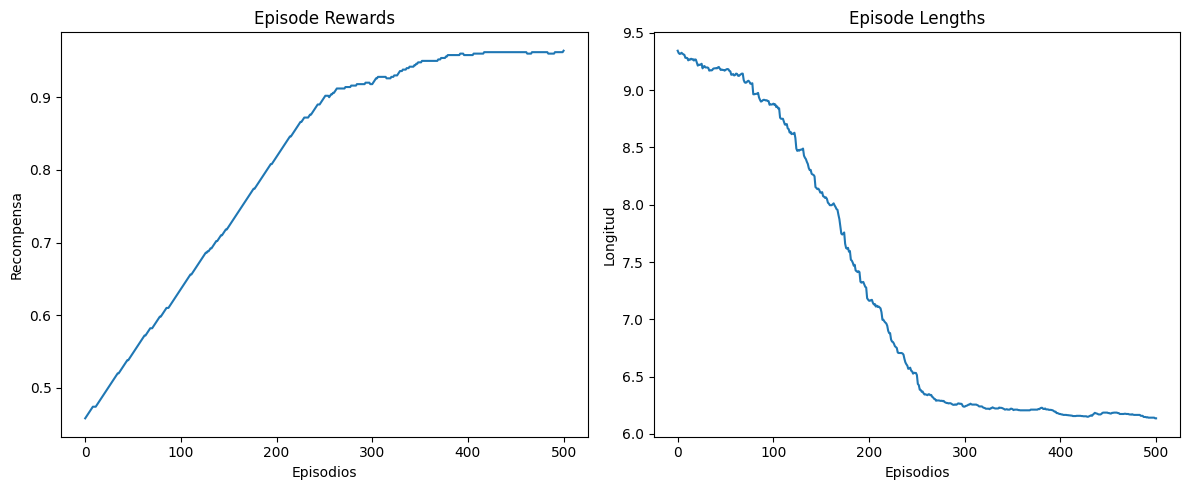

In [ ]:
from src_agents.deepQLearning import *
import random
import numpy as np
import torch
import gymnasium as gym

# Fijar la semilla en las diferentes librerías
seed = 1995
random.seed(seed)
np.random.seed(seed)


# Inicialización del entorno con el mapa 8x8
env = gym.make('FrozenLake-v1', is_slippery=False, map_name="4x4")

# Entrenar el agente DQN utilizando la semilla fija
episode_rewards, episode_lengths, training_errors, policy_net, target_net = train_dqn(env, num_episodes=1000, seed=seed)

# Visualización de resultados
visualizer = GraphVisualizer(episode_rewards, episode_lengths, training_errors, rolling_length=500)
visualizer.plot_all()


### 3.6 Sarsa SemiGradiente

#### Mapa 4x4

## **4. Conclusión**

c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\RL_FJLGM\src_agents\sarsaSemiGradiente.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Episode 50, Average Reward: 0.04, Epsilon: 0.78
Episode 100, Average Reward: 0.02, Epsilon: 0.61
Episode 150, Average Reward: 0.16, Epsilon: 0.47
Episode 200, Average Reward: 0.62, Epsilon: 0.37
Episode 250, Average Reward: 0.58, Epsilon: 0.29
Episode 300, Average Reward: 0.72, Epsilon: 0.22
Episode 350, Average Reward: 0.76, Epsilon: 0.17
Episode 400, Average Reward: 0.88, Epsilon: 0.13
Episode 450, Average Reward: 0.90, Epsilon: 0.10
Episode 500, Average Reward: 0.86, Epsilon: 0.10
Episode 550, Average Reward: 0.88, Epsilon: 0.10
Episode 600, Average Reward: 0.78, Epsilon: 0.10
Episode 650, Average Reward: 0.82, Epsilon: 0.10
Episode 700, Average Reward: 0.80, Epsilon: 0.10
Episode 750, Average Reward: 0.92, Epsilon: 0.10
Episode 800, Average Reward: 0.90, Epsilon: 0.10
Episode 850, Average Reward: 0.84, Epsilon: 0.10
Episode 900, Average Reward: 0.86, Epsilon: 0.10
Episode 950, Average Reward: 0.84, Epsilon: 0.10
Episode 1000, Average Reward: 0.92, Epsilon: 0.10
Política extraída (a

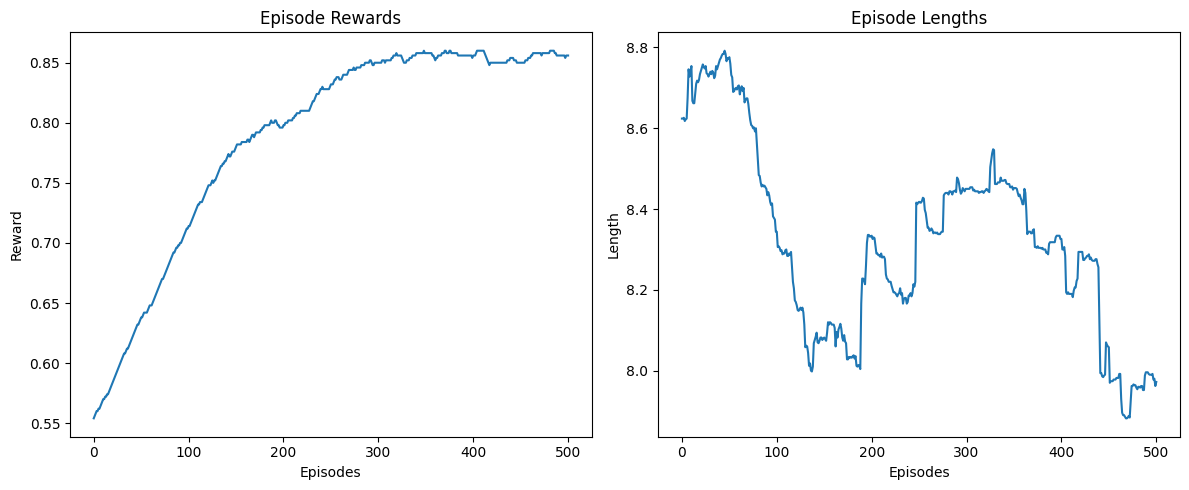

In [ ]:
from src_agents.sarsaSemiGradiente import *   


 # Fijar la semilla para reproducibilidad
seed = 1995
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
    
    # Inicializar el entorno (por ejemplo, mapa 8x8 sin deslizamiento)
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="4x4")
state_size = env_wrapper.observation_space.n
action_size = env_wrapper.action_space.n
    
    # Crear el agente SARSA
agent = SarsaSemigrad(state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99,
                       epsilon=1.0, min_epsilon=0.1, decay_rate=0.995)
    
    # Entrenar el agente SARSA
episode_rewards, episode_lengths, trained_agent = train_sarsa(env_wrapper, agent, num_episodes=1000, seed=seed)
    
    # Calcular la Q-table a partir del modelo entrenado
Q_table = np.zeros((state_size, action_size))
for s in range(state_size):
    s_one_hot = one_hot(s, state_size)
    with torch.no_grad():
        Q_table[s] = trained_agent.model(torch.FloatTensor(s_one_hot).unsqueeze(0)).numpy()[0]
policy_actions = [np.argmax(Q_table[s]) for s in range(state_size)]
print("Política extraída (acción por estado):")
print(policy_actions)
    
    # Visualizar estadísticas de entrenamiento
visualizer = GraphVisualizer(episode_rewards, episode_lengths, rolling_length=500)
visualizer.plot_all()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def plot_all_three(list_stats, episode_lengths, Q, env, actions, window=50):
    """
    Muestra en una sola figura:
      1) Recompensa total por episodio.
      2) Longitud de los episodios (con media móvil).
      3) Política aprendida en el entorno (flechas).

    Parámetros:
    -----------
    list_stats : list
        Lista con las recompensas totales por episodio.
    episode_lengths : list
        Lista con la longitud (número de pasos) de cada episodio.
    Q : np.ndarray
        Q-table con dimensiones [n_estados, n_acciones].
    env : gym.Env o wrapper
        Entorno FrozenLake (ej. FrozenLake-v1). Si es un wrapper, se accederá a env.env.
    actions : list[int]
        Lista de enteros (0,1,2,3) que representan la política escogida por el agente.
    window : int
        Tamaño de la ventana para calcular la media móvil de la longitud de episodios.
    """
    
    # Usamos el entorno interno si se trata de un wrapper
    if hasattr(env, 'env'):
        env_inner = env.env
    else:
        env_inner = env
    
    # Crear la figura con 3 subplots en una fila
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1) Recompensa total por episodio
    indices = list(range(len(list_stats)))
    ax1.plot(indices, list_stats, label="Recompensa Total", color="blue")
    ax1.set_title("Recompensa Total por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.grid(True)
    ax1.legend()
    
    # 2) Longitud de episodios (con media móvil)
    indices = list(range(len(episode_lengths)))
    ax2.plot(indices, episode_lengths, label="Longitud de episodio", alpha=0.6, color="green")
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode="valid")
        ax2.plot(range(window-1, len(episode_lengths)), moving_avg,
                 label=f"Media Móvil (window={window})", color='red', linewidth=2)
    ax2.set_title("Longitud de los Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Número de pasos")
    ax2.grid(True)
    ax2.legend()
    
    # 3) Política aprendida (mapa de FrozenLake con flechas)
    arrow_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    num_filas, num_columnas = env_inner.unwrapped.desc.shape
    best_actions = [np.argmax(Q[s]) for s in range(env_inner.observation_space.n)]
    best_actions_2d = np.reshape(best_actions, (num_filas, num_columnas))
    
    ax3.set_xlim(-0.5, num_columnas - 0.5)
    ax3.set_ylim(num_filas - 0.5, -0.5)
    
    # Dibujar cada celda con su color según el tipo
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env_inner.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                color = "gray"
            elif celda == 'G':
                color = "green"
            elif celda == 'F':
                color = "skyblue"
            elif celda == 'H':
                color = "red"
            else:
                color = "white"
            ax3.add_patch(plt.Rectangle((columna - 0.5, fila - 0.5),
                                        1, 1, color=color, ec="black"))
    
    # Añadir texto en cada celda
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env_inner.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                ax3.text(columna, fila, "Start", ha="center", va="center",
                         fontsize=12, color="white", fontweight="bold")
            elif celda in ['H', 'G']:
                ax3.text(columna, fila, celda, ha="center", va="center",
                         fontsize=14, color="white", fontweight="bold")
            else:
                accion_optima = best_actions_2d[fila, columna]
                flecha = arrow_dict.get(accion_optima, '?')
                ax3.text(columna, fila, flecha, ha="center", va="center",
                         fontsize=16, color="black", fontweight="bold")
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Política Aprendida", pad=10)
    
    # Leyenda de flechas y colores
    left_arrow = mlines.Line2D([], [], color='black', marker=r'$\leftarrow$', 
                               linestyle='None', markersize=12, label='Acción 0: Izquierda')
    down_arrow = mlines.Line2D([], [], color='black', marker=r'$\downarrow$', 
                               linestyle='None', markersize=12, label='Acción 1: Abajo')
    right_arrow = mlines.Line2D([], [], color='black', marker=r'$\rightarrow$', 
                                linestyle='None', markersize=12, label='Acción 2: Derecha')
    up_arrow = mlines.Line2D([], [], color='black', marker=r'$\uparrow$', 
                             linestyle='None', markersize=12, label='Acción 3: Arriba')
    patch_s = mpatches.Patch(color="gray", label="S (Inicio)")
    patch_f = mpatches.Patch(color="skyblue", label="F (Hielo)")
    patch_h = mpatches.Patch(color="red", label="H (Agua)")
    patch_g = mpatches.Patch(color="green", label="G (Meta)")
    
    policy_str = str(actions)
    policy_line = mlines.Line2D([], [], color='none', marker='',
                                linestyle='None', markersize=12, label=f"\n Política escogida: {policy_str}")
    
    legend_handles = [left_arrow, down_arrow, right_arrow, up_arrow,
                      patch_s, patch_f, patch_h, patch_g,
                      policy_line]
    
    ax3.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
               loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()


Entrenando SARSA Semigradiente:   2%|▍                     | 104/5000 [00:02<01:56, 42.10episodio/s]

Episodio 100/5000, Recompensa Promedio: 0.01, Epsilon: 0.905


Entrenando SARSA Semigradiente:   4%|▉                     | 202/5000 [00:04<01:50, 43.55episodio/s]

Episodio 200/5000, Recompensa Promedio: 0.02, Epsilon: 0.819


Entrenando SARSA Semigradiente:   6%|█▎                    | 303/5000 [00:07<02:15, 34.62episodio/s]

Episodio 300/5000, Recompensa Promedio: 0.01, Epsilon: 0.741


Entrenando SARSA Semigradiente:   8%|█▊                    | 403/5000 [00:10<02:41, 28.41episodio/s]

Episodio 400/5000, Recompensa Promedio: 0.03, Epsilon: 0.670


Entrenando SARSA Semigradiente:  10%|██▏                   | 505/5000 [00:13<01:49, 41.14episodio/s]

Episodio 500/5000, Recompensa Promedio: 0.05, Epsilon: 0.607


Entrenando SARSA Semigradiente:  12%|██▋                   | 608/5000 [00:16<01:49, 40.28episodio/s]

Episodio 600/5000, Recompensa Promedio: 0.19, Epsilon: 0.549


Entrenando SARSA Semigradiente:  14%|███                   | 704/5000 [00:18<01:24, 50.96episodio/s]

Episodio 700/5000, Recompensa Promedio: 0.54, Epsilon: 0.497


Entrenando SARSA Semigradiente:  16%|███▌                  | 799/5000 [00:21<02:17, 30.60episodio/s]

Episodio 800/5000, Recompensa Promedio: 0.48, Epsilon: 0.449


Entrenando SARSA Semigradiente:  18%|███▉                  | 908/5000 [00:24<01:37, 41.99episodio/s]

Episodio 900/5000, Recompensa Promedio: 0.59, Epsilon: 0.407


Entrenando SARSA Semigradiente:  20%|████▏                | 1008/5000 [00:26<01:20, 49.57episodio/s]

Episodio 1000/5000, Recompensa Promedio: 0.69, Epsilon: 0.368


Entrenando SARSA Semigradiente:  22%|████▋                | 1103/5000 [00:28<01:37, 39.93episodio/s]

Episodio 1100/5000, Recompensa Promedio: 0.76, Epsilon: 0.333


Entrenando SARSA Semigradiente:  24%|█████                | 1205/5000 [00:30<01:22, 46.08episodio/s]

Episodio 1200/5000, Recompensa Promedio: 0.69, Epsilon: 0.301


Entrenando SARSA Semigradiente:  26%|█████▍               | 1308/5000 [00:33<01:19, 46.46episodio/s]

Episodio 1300/5000, Recompensa Promedio: 0.81, Epsilon: 0.273


Entrenando SARSA Semigradiente:  28%|█████▉               | 1404/5000 [00:35<01:25, 42.02episodio/s]

Episodio 1400/5000, Recompensa Promedio: 0.81, Epsilon: 0.247


Entrenando SARSA Semigradiente:  30%|██████▎              | 1502/5000 [00:37<01:16, 45.59episodio/s]

Episodio 1500/5000, Recompensa Promedio: 0.81, Epsilon: 0.223


Entrenando SARSA Semigradiente:  32%|██████▊              | 1610/5000 [00:39<01:03, 53.21episodio/s]

Episodio 1600/5000, Recompensa Promedio: 0.84, Epsilon: 0.202


Entrenando SARSA Semigradiente:  34%|███████▏             | 1707/5000 [00:41<01:05, 50.66episodio/s]

Episodio 1700/5000, Recompensa Promedio: 0.82, Epsilon: 0.183


Entrenando SARSA Semigradiente:  36%|███████▌             | 1811/5000 [00:43<00:57, 55.16episodio/s]

Episodio 1800/5000, Recompensa Promedio: 0.84, Epsilon: 0.165


Entrenando SARSA Semigradiente:  38%|████████             | 1908/5000 [00:45<01:07, 45.79episodio/s]

Episodio 1900/5000, Recompensa Promedio: 0.90, Epsilon: 0.150


Entrenando SARSA Semigradiente:  40%|████████▍            | 2005/5000 [00:47<00:58, 51.48episodio/s]

Episodio 2000/5000, Recompensa Promedio: 0.87, Epsilon: 0.135


Entrenando SARSA Semigradiente:  42%|████████▊            | 2106/5000 [00:49<00:53, 53.78episodio/s]

Episodio 2100/5000, Recompensa Promedio: 0.91, Epsilon: 0.122


Entrenando SARSA Semigradiente:  44%|█████████▏           | 2199/5000 [00:51<00:52, 52.93episodio/s]

Episodio 2200/5000, Recompensa Promedio: 0.89, Epsilon: 0.111


Entrenando SARSA Semigradiente:  46%|█████████▋           | 2303/5000 [00:54<01:07, 39.84episodio/s]

Episodio 2300/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  48%|██████████           | 2407/5000 [00:55<00:43, 59.62episodio/s]

Episodio 2400/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  50%|██████████▌          | 2508/5000 [00:57<00:38, 65.19episodio/s]

Episodio 2500/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  52%|██████████▉          | 2607/5000 [00:59<00:51, 46.13episodio/s]

Episodio 2600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  54%|███████████▎         | 2708/5000 [01:01<00:37, 60.65episodio/s]

Episodio 2700/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  56%|███████████▊         | 2804/5000 [01:03<00:49, 44.48episodio/s]

Episodio 2800/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  58%|████████████▏        | 2909/5000 [01:05<00:36, 57.87episodio/s]

Episodio 2900/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  60%|████████████▋        | 3007/5000 [01:07<00:35, 56.19episodio/s]

Episodio 3000/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  62%|█████████████        | 3104/5000 [01:09<00:43, 43.72episodio/s]

Episodio 3100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  64%|█████████████▍       | 3209/5000 [01:11<00:28, 61.88episodio/s]

Episodio 3200/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  66%|█████████████▉       | 3307/5000 [01:12<00:28, 58.53episodio/s]

Episodio 3300/5000, Recompensa Promedio: 0.95, Epsilon: 0.100


Entrenando SARSA Semigradiente:  68%|██████████████▎      | 3406/5000 [01:14<00:30, 51.91episodio/s]

Episodio 3400/5000, Recompensa Promedio: 0.89, Epsilon: 0.100


Entrenando SARSA Semigradiente:  70%|██████████████▋      | 3505/5000 [01:16<00:29, 50.92episodio/s]

Episodio 3500/5000, Recompensa Promedio: 0.88, Epsilon: 0.100


Entrenando SARSA Semigradiente:  72%|███████████████▏     | 3605/5000 [01:18<00:22, 62.43episodio/s]

Episodio 3600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  74%|███████████████▌     | 3708/5000 [01:20<00:21, 60.21episodio/s]

Episodio 3700/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  76%|███████████████▉     | 3806/5000 [01:22<00:18, 63.05episodio/s]

Episodio 3800/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  78%|████████████████▍    | 3906/5000 [01:23<00:19, 56.49episodio/s]

Episodio 3900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  80%|████████████████▊    | 4005/5000 [01:25<00:16, 59.13episodio/s]

Episodio 4000/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  82%|█████████████████▏   | 4107/5000 [01:27<00:15, 58.09episodio/s]

Episodio 4100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  84%|█████████████████▋   | 4206/5000 [01:29<00:13, 59.69episodio/s]

Episodio 4200/5000, Recompensa Promedio: 0.93, Epsilon: 0.100


Entrenando SARSA Semigradiente:  86%|██████████████████   | 4308/5000 [01:30<00:11, 61.86episodio/s]

Episodio 4300/5000, Recompensa Promedio: 0.98, Epsilon: 0.100


Entrenando SARSA Semigradiente:  88%|██████████████████▌  | 4408/5000 [01:33<00:11, 51.41episodio/s]

Episodio 4400/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


Entrenando SARSA Semigradiente:  90%|██████████████████▉  | 4505/5000 [01:34<00:08, 57.40episodio/s]

Episodio 4500/5000, Recompensa Promedio: 0.97, Epsilon: 0.100


Entrenando SARSA Semigradiente:  92%|███████████████████▎ | 4608/5000 [01:36<00:06, 60.31episodio/s]

Episodio 4600/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  94%|███████████████████▊ | 4705/5000 [01:38<00:05, 55.02episodio/s]

Episodio 4700/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  96%|████████████████████▏| 4811/5000 [01:40<00:03, 55.80episodio/s]

Episodio 4800/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  98%|████████████████████▌| 4910/5000 [01:41<00:01, 55.11episodio/s]

Episodio 4900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente: 100%|█████████████████████| 5000/5000 [01:43<00:00, 48.23episodio/s]


Episodio 5000/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


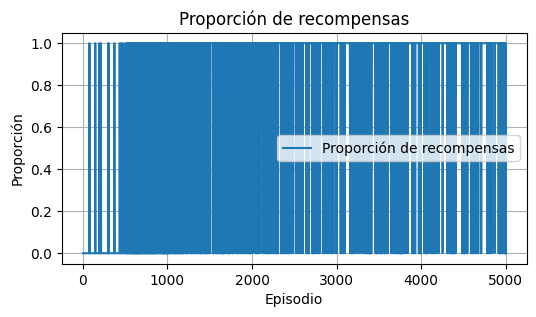

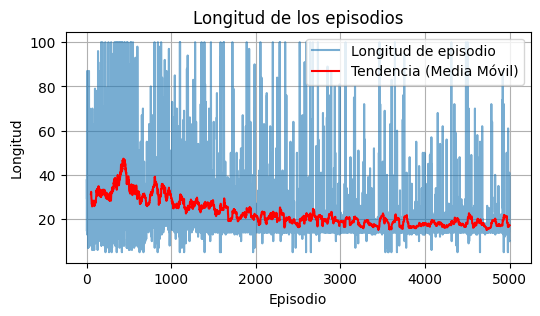

In [ ]:
# Importar las librerías necesarias
import numpy as np
import random
import gymnasium as gym
import torch
from src_agents import SarsaSemigradiente, pi_star_from_Q, plot, plot_comparison

# Establecer semillas para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value) if torch.cuda.is_available() else None

# Crear el entorno
env_sarsa_sg = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

# Inicializar el agente
agente_sarsa_sg = SarsaSemigradiente(
    env=env_sarsa_sg, 
    epsilon=1.0,               # Epsilon inicial alto para exploración
    gamma=0.99,                # Factor de descuento
    learning_rate=0.001,       # Tasa de aprendizaje para la red neuronal
    hidden_size=64,            # Tamaño de la capa oculta
    min_epsilon=0.1,           # Valor mínimo de epsilon después del decaimiento
    exploration_decay_rate=0.001,  # Tasa de decaimiento de epsilon
    seed=seed_value            # Semilla para reproducibilidad
)

# Entrenar el agente
rewards_sarsa_sg, episode_lengths_sarsa_sg = agente_sarsa_sg.entrenar(num_episodios=5000)

# Obtener la política óptima
# Nota: La política óptima para redes neuronales puede ser diferente a la Q-table
# Aquí construimos una Q-table a partir de las predicciones de la red
Q_sarsa_sg = np.zeros((env_sarsa_sg.observation_space.n, env_sarsa_sg.action_space.n))

for state in range(env_sarsa_sg.observation_space.n):
    # Convertir estado a one-hot
    state_one_hot = np.zeros(env_sarsa_sg.observation_space.n, dtype=np.float32)
    state_one_hot[state] = 1.0
    
    # Obtener valores Q desde la red neuronal
    state_tensor = torch.FloatTensor(state_one_hot).unsqueeze(0)
    with torch.no_grad():
        q_values = agente_sarsa_sg.model(state_tensor).numpy()[0]
    
    # Guardar valores en la Q-table
    Q_sarsa_sg[state] = q_values

# Obtener la política óptima usando la Q-table generada
pi_star_sarsa_sg, actions_sarsa_sg = pi_star_from_Q(env_sarsa_sg, Q_sarsa_sg)

# Visualizar resultados
plot(rewards_sarsa_sg)
plot_episode_lengths(episode_lengths_sarsa_sg)

# Si quieres comparar con otros agentes
# plot_comparison([stats_mc_on_policy, rewards_sarsa_sg], 
#                ["Monte Carlo On-Policy", "SARSA Semigradiente"])

Entrenando SARSA Semigradiente:   0%|                                | 0/5000 [00:00<?, ?episodio/s]c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\RL_FJLGM\src_agents\sarsaSemiGradiente.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  objetivo = torch.tensor(objetivo)
Entrenando SARSA Semigradiente:   2%|▍                     | 108/5000 [00:02<02:00, 40.66episodio/s]

Episodio 100/5000, Recompensa Promedio: 0.01, Epsilon: 0.905


Entrenando SARSA Semigradiente:   4%|▉                     | 205/5000 [00:05<02:05, 38.17episodio/s]

Episodio 200/5000, Recompensa Promedio: 0.02, Epsilon: 0.819


Entrenando SARSA Semigradiente:   6%|█▎                    | 301/5000 [00:08<02:27, 31.90episodio/s]

Episodio 300/5000, Recompensa Promedio: 0.01, Epsilon: 0.741


Entrenando SARSA Semigradiente:   8%|█▊                    | 404/5000 [00:11<02:50, 26.93episodio/s]

Episodio 400/5000, Recompensa Promedio: 0.03, Epsilon: 0.670


Entrenando SARSA Semigradiente:  10%|██▏                   | 509/5000 [00:15<01:48, 41.29episodio/s]

Episodio 500/5000, Recompensa Promedio: 0.05, Epsilon: 0.607


Entrenando SARSA Semigradiente:  12%|██▋                   | 603/5000 [00:17<02:07, 34.54episodio/s]

Episodio 600/5000, Recompensa Promedio: 0.19, Epsilon: 0.549


Entrenando SARSA Semigradiente:  14%|███                   | 708/5000 [00:20<01:34, 45.43episodio/s]

Episodio 700/5000, Recompensa Promedio: 0.54, Epsilon: 0.497


Entrenando SARSA Semigradiente:  16%|███▌                  | 801/5000 [00:23<02:44, 25.58episodio/s]

Episodio 800/5000, Recompensa Promedio: 0.48, Epsilon: 0.449


Entrenando SARSA Semigradiente:  18%|███▉                  | 907/5000 [00:26<01:45, 38.89episodio/s]

Episodio 900/5000, Recompensa Promedio: 0.59, Epsilon: 0.407


Entrenando SARSA Semigradiente:  20%|████▏                | 1008/5000 [00:29<01:29, 44.36episodio/s]

Episodio 1000/5000, Recompensa Promedio: 0.69, Epsilon: 0.368


Entrenando SARSA Semigradiente:  22%|████▋                | 1102/5000 [00:31<01:46, 36.72episodio/s]

Episodio 1100/5000, Recompensa Promedio: 0.76, Epsilon: 0.333


Entrenando SARSA Semigradiente:  24%|█████                | 1204/5000 [00:33<01:30, 42.12episodio/s]

Episodio 1200/5000, Recompensa Promedio: 0.69, Epsilon: 0.301


Entrenando SARSA Semigradiente:  26%|█████▍               | 1307/5000 [00:36<01:24, 43.74episodio/s]

Episodio 1300/5000, Recompensa Promedio: 0.81, Epsilon: 0.273


Entrenando SARSA Semigradiente:  28%|█████▉               | 1406/5000 [00:38<01:32, 39.04episodio/s]

Episodio 1400/5000, Recompensa Promedio: 0.81, Epsilon: 0.247


Entrenando SARSA Semigradiente:  30%|██████▎              | 1504/5000 [00:41<01:27, 40.16episodio/s]

Episodio 1500/5000, Recompensa Promedio: 0.81, Epsilon: 0.223


Entrenando SARSA Semigradiente:  32%|██████▋              | 1607/5000 [00:43<01:13, 45.89episodio/s]

Episodio 1600/5000, Recompensa Promedio: 0.84, Epsilon: 0.202


Entrenando SARSA Semigradiente:  34%|███████▏             | 1708/5000 [00:45<01:21, 40.20episodio/s]

Episodio 1700/5000, Recompensa Promedio: 0.82, Epsilon: 0.183


Entrenando SARSA Semigradiente:  36%|███████▌             | 1812/5000 [00:48<01:03, 50.14episodio/s]

Episodio 1800/5000, Recompensa Promedio: 0.84, Epsilon: 0.165


Entrenando SARSA Semigradiente:  38%|███████▉             | 1903/5000 [00:50<01:20, 38.66episodio/s]

Episodio 1900/5000, Recompensa Promedio: 0.90, Epsilon: 0.150


Entrenando SARSA Semigradiente:  40%|████████▍            | 2011/5000 [00:52<00:57, 51.82episodio/s]

Episodio 2000/5000, Recompensa Promedio: 0.87, Epsilon: 0.135


Entrenando SARSA Semigradiente:  42%|████████▊            | 2108/5000 [00:54<00:56, 51.27episodio/s]

Episodio 2100/5000, Recompensa Promedio: 0.91, Epsilon: 0.122


Entrenando SARSA Semigradiente:  44%|█████████▏           | 2200/5000 [00:56<01:05, 42.99episodio/s]

Episodio 2200/5000, Recompensa Promedio: 0.89, Epsilon: 0.111


Entrenando SARSA Semigradiente:  46%|█████████▋           | 2308/5000 [00:59<00:55, 48.37episodio/s]

Episodio 2300/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  48%|██████████           | 2407/5000 [01:00<00:45, 56.58episodio/s]

Episodio 2400/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  50%|██████████▌          | 2507/5000 [01:02<00:40, 61.78episodio/s]

Episodio 2500/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  52%|██████████▉          | 2607/5000 [01:04<00:50, 47.06episodio/s]

Episodio 2600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  54%|███████████▎         | 2708/5000 [01:06<00:39, 57.34episodio/s]

Episodio 2700/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  56%|███████████▊         | 2808/5000 [01:09<00:46, 47.18episodio/s]

Episodio 2800/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  58%|████████████▏        | 2910/5000 [01:11<00:39, 53.40episodio/s]

Episodio 2900/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  60%|████████████▋        | 3008/5000 [01:13<00:38, 51.84episodio/s]

Episodio 3000/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  62%|█████████████        | 3104/5000 [01:14<00:35, 53.83episodio/s]

Episodio 3100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  64%|█████████████▍       | 3204/5000 [01:16<00:32, 55.56episodio/s]

Episodio 3200/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  66%|█████████████▉       | 3310/5000 [01:18<00:29, 57.25episodio/s]

Episodio 3300/5000, Recompensa Promedio: 0.95, Epsilon: 0.100


Entrenando SARSA Semigradiente:  68%|██████████████▎      | 3412/5000 [01:20<00:27, 58.34episodio/s]

Episodio 3400/5000, Recompensa Promedio: 0.89, Epsilon: 0.100


Entrenando SARSA Semigradiente:  70%|██████████████▋      | 3504/5000 [01:22<00:30, 49.14episodio/s]

Episodio 3500/5000, Recompensa Promedio: 0.88, Epsilon: 0.100


Entrenando SARSA Semigradiente:  72%|███████████████▏     | 3606/5000 [01:24<00:26, 51.78episodio/s]

Episodio 3600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  74%|███████████████▌     | 3711/5000 [01:26<00:20, 62.07episodio/s]

Episodio 3700/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  76%|████████████████     | 3812/5000 [01:27<00:19, 61.74episodio/s]

Episodio 3800/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  78%|████████████████▍    | 3904/5000 [01:29<00:19, 56.42episodio/s]

Episodio 3900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  80%|████████████████▊    | 4011/5000 [01:31<00:16, 58.82episodio/s]

Episodio 4000/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  82%|█████████████████▏   | 4106/5000 [01:33<00:18, 49.17episodio/s]

Episodio 4100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  84%|█████████████████▋   | 4205/5000 [01:35<00:13, 60.07episodio/s]

Episodio 4200/5000, Recompensa Promedio: 0.93, Epsilon: 0.100


Entrenando SARSA Semigradiente:  86%|██████████████████   | 4306/5000 [01:36<00:12, 55.49episodio/s]

Episodio 4300/5000, Recompensa Promedio: 0.98, Epsilon: 0.100


Entrenando SARSA Semigradiente:  88%|██████████████████▌  | 4409/5000 [01:38<00:10, 55.99episodio/s]

Episodio 4400/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


Entrenando SARSA Semigradiente:  90%|██████████████████▉  | 4504/5000 [01:40<00:09, 50.18episodio/s]

Episodio 4500/5000, Recompensa Promedio: 0.97, Epsilon: 0.100


Entrenando SARSA Semigradiente:  92%|███████████████████▎ | 4608/5000 [01:42<00:06, 56.84episodio/s]

Episodio 4600/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  94%|███████████████████▊ | 4713/5000 [01:44<00:04, 62.30episodio/s]

Episodio 4700/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  96%|████████████████████▏| 4812/5000 [01:46<00:03, 50.99episodio/s]

Episodio 4800/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  98%|████████████████████▌| 4910/5000 [01:48<00:01, 57.44episodio/s]

Episodio 4900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente: 100%|█████████████████████| 5000/5000 [01:50<00:00, 45.43episodio/s]


Episodio 5000/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


AttributeError: 'FrozenLakeWrapper' object has no attribute 'unwrapped'

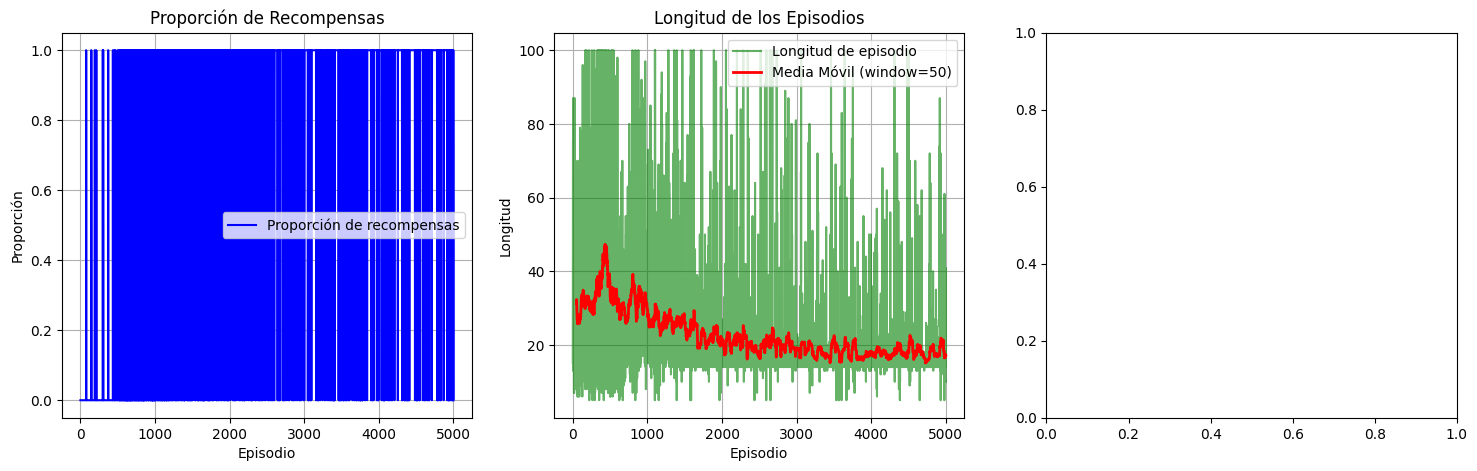

In [ ]:
import gymnasium as gym
import torch
import numpy as np
import random

from src_agents import SarsaSemigradiente, pi_star_from_Q

# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)

# Crear el entorno utilizando el wrapper (8x8, no resbaladizo)
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="8x8")

# Obtener dimensiones del entorno
state_size = env_wrapper.observation_space.n   # Por ejemplo, 64 para un mapa 8x8
action_size = env_wrapper.action_space.n         # Normalmente 4

# Inicializar el agente SARSA semigradiente
agent = SarsaSemigradiente(
    env=env_wrapper, 
    epsilon=1.0,               # Epsilon inicial alto para exploración
    gamma=0.99,                # Factor de descuento
    learning_rate=0.001,       # Tasa de aprendizaje para la red neuronal
    hidden_size=64,            # Tamaño de la capa oculta
    min_epsilon=0.1,           # Valor mínimo de epsilon después del decaimiento
    exploration_decay_rate=0.001,  # Tasa de decaimiento de epsilon
    seed=seed_value            # Semilla para reproducibilidad
)

# Entrenar el agente (por ejemplo, durante 5000 episodios)
num_episodios = 5000
rewards_sarsa_sg, episode_lengths_sarsa_sg = agent.entrenar(num_episodios=num_episodios)

# Construir una Q-table a partir del modelo entrenado
Q_sarsa_sg = np.zeros((state_size, action_size))
for s in range(state_size):
    state_one_hot = np.zeros(state_size, dtype=np.float32)
    state_one_hot[s] = 1.0
    with torch.no_grad():
        Q_sarsa_sg[s] = agent.model(torch.FloatTensor(state_one_hot).unsqueeze(0)).numpy()[0]

# Obtener la política óptima a partir de la Q-table
pi_star_sarsa_sg, actions_sarsa_sg = pi_star_from_Q(env_wrapper, Q_sarsa_sg)

# Graficar los resultados utilizando plot_all_three:
plot_all_three(
    list_stats=rewards_sarsa_sg, 
    episode_lengths=episode_lengths_sarsa_sg, 
    Q=Q_sarsa_sg, 
    env=env_wrapper, 
    actions=actions_sarsa_sg, 
    window=50
)


In [ ]:
import numpy as np
import random
import gymnasium as gym
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


# Establecer semillas para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random
torch.manual_seed(seed_value)  # Establecer semilla de PyTorch

# Función auxiliar para extraer Q-values de la red neuronal para todos los estados
def extract_Q_from_model(model, env):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))
    
    for state in range(num_states):
        # Convertir estado a tensor one-hot
        state_tensor = torch.zeros(num_states)
        state_tensor[state] = 1.0
        state_tensor = state_tensor.unsqueeze(0)  # Añadir dimensión de batch
        
        # Obtener valores Q para el estado
        with torch.no_grad():
            q_values = model(state_tensor).squeeze(0).numpy()
        
        # Guardar valores Q
        Q[state] = q_values
    
    return Q

# Creación del entorno
env_sarsa_sg_8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

# Creación y entrenamiento del agente Sarsa Semigradiente
agente_sarsa_sg_8x8 = SarsaSemigradiente(
    env=env_sarsa_sg_8x8, 
    epsilon=1.0, 
    gamma=0.99, 
    alpha=0.001,  # Tasa de aprendizaje más baja para la red neuronal
    decay=True, 
    num_episodios=5000,
    hidden_size=64  # Tamaño de la capa oculta
)

# Entrenamiento del agente
model_sarsa_sg_8x8, stats_sarsa_sg_8x8, episode_lengths_sarsa_sg_8x8 = agente_sarsa_sg_8x8.entrenar()

# Extraer Q-values del modelo entrenado
Q_sarsa_sg_8x8 = extract_Q_from_model(model_sarsa_sg_8x8, env_sarsa_sg_8x8)

# Obtener política óptima a partir de los Q-values
pi_sarsa_sg_8x8, actions_sarsa_sg_8x8 = pi_star_from_Q(env_sarsa_sg_8x8, Q_sarsa_sg_8x8)





Entrenando: 100%|█████████████████████████████████████████| 5000/5000 [02:15<00:00, 36.96episodio/s]


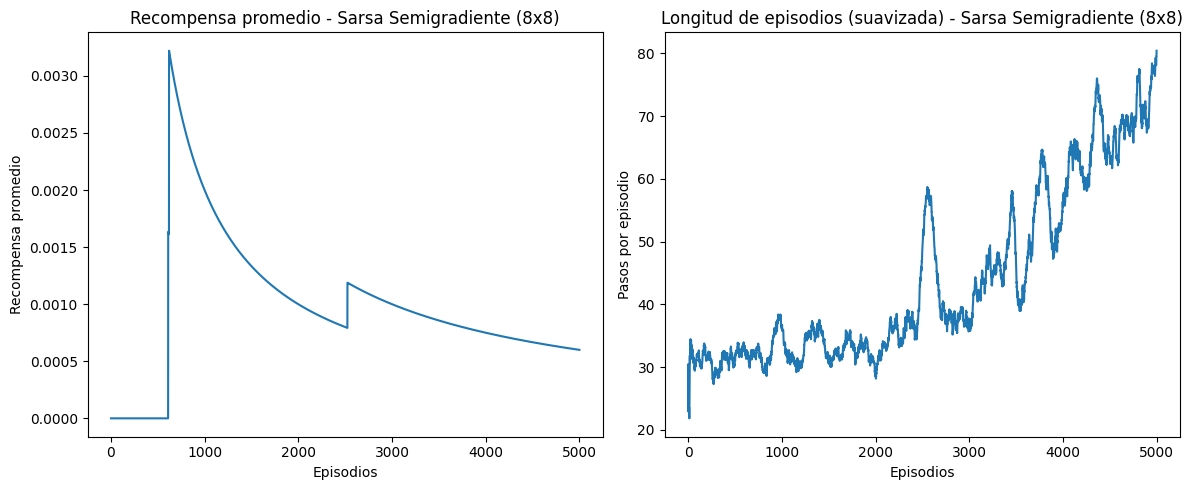

In [ ]:
# Visualización de resultados
plt.figure(figsize=(12, 5))

# Gráfico de recompensa promedio
plt.subplot(1, 2, 1)
plt.plot(stats_sarsa_sg_8x8)
plt.title('Recompensa promedio - Sarsa Semigradiente (8x8)')
plt.xlabel('Episodios')
plt.ylabel('Recompensa promedio')

# Gráfico de longitud de episodios
plt.subplot(1, 2, 2)
window_size = 100
episode_lengths_smoothed = [np.mean(episode_lengths_sarsa_sg_8x8[max(0, i-window_size):i+1]) 
                           for i in range(len(episode_lengths_sarsa_sg_8x8))]
plt.plot(episode_lengths_smoothed)
plt.title('Longitud de episodios (suavizada) - Sarsa Semigradiente (8x8)')
plt.xlabel('Episodios')
plt.ylabel('Pasos por episodio')

plt.tight_layout()
plt.show()

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Función que codifica (estado, acción) en un vector one-hot
def one_hot(state, n_states, action, n_actions):
    vec = np.zeros(n_states * n_actions)
    index = state * n_actions + action
    vec[index] = 1
    return vec

# Función Q aproximada: Q(s,a) = theta^T * phi(s,a)
def get_q(theta, state, n_states, action, n_actions):
    phi = one_hot(state, n_states, action, n_actions)
    return np.dot(theta, phi)

# Obtiene los valores Q para todas las acciones en un estado dado
def get_q_all(theta, state, n_states, n_actions):
    return np.array([get_q(theta, state, n_states, a, n_actions) for a in range(n_actions)])

# Política epsilon-greedy basada en la aproximación Q
def epsilon_greedy(theta, state, n_states, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        q_values = get_q_all(theta, state, n_states, n_actions)
        return np.argmax(q_values)

# Función de entrenamiento usando SARSA semigradiente
def train_sarsa_semigradiente(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Inicializamos los parámetros (theta) con ceros
    theta = np.zeros(n_states * n_actions)
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        # Reiniciamos el ambiente
        observation, info = env.reset()
        state = observation
        action = epsilon_greedy(theta, state, n_states, n_actions, epsilon)
        episode_reward = 0
        done = False
        
        # Se ejecuta el episodio
        while not done:
            next_obs, reward, done, truncated, info = env.step(action)
            next_state = next_obs
            episode_reward += reward
            
            # Si hemos alcanzado un estado terminal, actualizamos y rompemos
            if done:
                delta = reward - get_q(theta, state, n_states, action, n_actions)
                theta += alpha * delta * one_hot(state, n_states, action, n_actions)
                break
            else:
                next_action = epsilon_greedy(theta, next_state, n_states, n_actions, epsilon)
                # Cálculo del error TD (delta)
                delta = reward + gamma * get_q(theta, next_state, n_states, next_action, n_actions) - get_q(theta, state, n_states, action, n_actions)
                # Actualización semigradiente
                theta += alpha * delta * one_hot(state, n_states, action, n_actions)
                state = next_state
                action = next_action
        
        rewards_per_episode.append(episode_reward)
    
    return theta, rewards_per_episode

# Función para evaluar la política obtenida (usando selección greedy)
def evaluate_policy(env, theta, n_episodes=100, epsilon=0.0):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    rewards = []
    
    for episode in range(n_episodes):
        observation, info = env.reset()
        state = observation
        episode_reward = 0
        done = False
        
        while not done:
            action = epsilon_greedy(theta, state, n_states, n_actions, epsilon)
            next_obs, reward, done, truncated, info = env.step(action)
            state = next_obs
            episode_reward += reward
            if done:
                break
        rewards.append(episode_reward)
    
    return np.mean(rewards)

# Ejecución principal
if __name__ == "__main__":
    # Creamos el ambiente FrozenLake (modo determinista para facilitar el entrenamiento)
    env = gym.make("FrozenLake-v1", is_slippery=False)
    
    # Parámetros de entrenamiento
    num_episodes = 1000
    alpha = 0.1
    gamma = 0.99
    epsilon = 0.1
    
    # Entrenamos con SARSA semigradiente
    theta, rewards = train_sarsa_semigradiente(env, num_episodes, alpha, gamma, epsilon)
    
    # Evaluamos la política aprendida
    avg_reward = evaluate_policy(env, theta, n_episodes=100)
    print("Recompensa promedio en 100 episodios de evaluación:", avg_reward)
    
    # Graficamos la evolución de la recompensa durante el entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Recompensa por episodio durante el entrenamiento")
    plt.show()


KeyboardInterrupt: 